In [1]:
import os
import json
import urllib

import h5py
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [2]:
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.utils.data_utils import get_file

Using TensorFlow backend.


## Input

In [3]:
first_gate = applications.DenseNet201(weights='imagenet')

In [4]:
second_gate = load_model('data1a/Damaged_densenet_final.h5')

In [5]:
location_model = load_model('data2a/Location_densenet_final.h5')

In [6]:
severity_model = load_model('data3a/Severity_densenet_final.h5')

In [8]:
with open('vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)

## First Gate Setup - Car or Not?

In [57]:
# from Keras GitHub  
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [58]:
def prepare_img_224(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [59]:
def car_categories_gate(img_224, model):
    print ("Validating that this is a picture of your car...")
    out = model.predict(img_224)
    top = get_predictions(out, top=5)
    for j in top[0]:
        if j[0:2] in cat_list:
            # print j[0:2]
            return True # "Validation complete - proceed to damage evaluation"
    return False # "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

## Second Gate Setup - Damaged or Whole?

In [60]:
def prepare_img_256(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255
    return x

In [61]:
def car_damage_gate(img_256, model):
    print ("Validating that damage exists...")
    pred = model.predict(img_256)
    if pred[0][0] >=.5:
        return True # print "Validation complete - proceed to location and severity determination"
    else:
        return False
        # print "Are you sure that your car is damaged? Please submit another picture of the damage."
        # print "Hint: Try zooming in/out, using a different angle or different lighting"

## Location and Severity Assessment

In [62]:
def location_assessment(img_256, model):
    print ("Determining location of damage...")
    pred = model.predict(img_256)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Front', 1: 'Rear', 2: 'Side'}
    for key in d.keys():
        if pred_label[0] == key:
            print ("Assessment: {} damage to vehicle".format(d[key]))
    print ("Location assessment complete.")

In [63]:
def severity_assessment(img_256, model):
    print ("Determining severity of damage...")
    pred = model.predict(img_256)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print ("Assessment: {} damage to vehicle".format(d[key]))
    print ("Severity assessment complete.")

In [72]:
# load models
def engine(img_path):
    img_224 = prepare_img_224(img_path)
    g1 = car_categories_gate(img_224, first_gate)

    display(Image('save.jpg', width=300))

    if g1 is False:
        print ("Are you sure this is a picture of your car? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting.")
        

    img_256 = prepare_img_256(img_path)
    g2 = car_damage_gate(img_256, second_gate)

    if g2 is False:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting.")
        

    x = location_assessment(img_256, location_model)
    y = severity_assessment(img_256, severity_model)

Validating that this is a picture of your car...


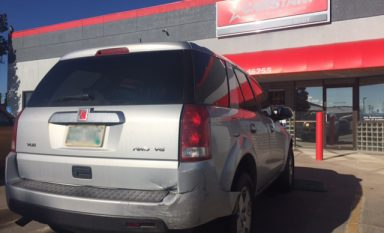

Validating that damage exists...
Determining location of damage...
Assessment: Rear damage to vehicle
Location assessment complete.
Determining severity of damage...
Assessment: Moderate damage to vehicle
Severity assessment complete.


In [70]:
engine('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

Validating that this is a picture of your car...


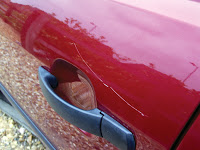

Are you sure this is a picture of your car? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.
Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.
Determining location of damage...
Assessment: Front damage to vehicle
Location assessment complete.
Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.


In [71]:
engine('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

Validating that this is a picture of your car...


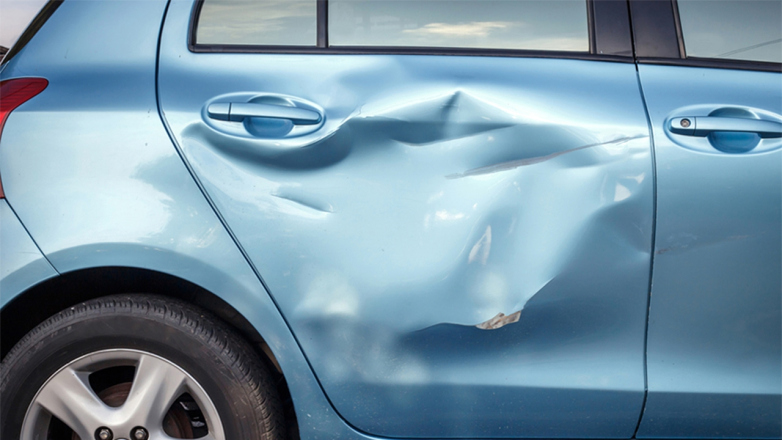

Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.
Determining location of damage...
Assessment: Side damage to vehicle
Location assessment complete.
Determining severity of damage...
Assessment: Moderate damage to vehicle
Severity assessment complete.


In [73]:
engine('https://boygeniusreport.files.wordpress.com/2017/09/dented-car.jpg?quality=98&strip=all&w=782')

Validating that this is a picture of your car...


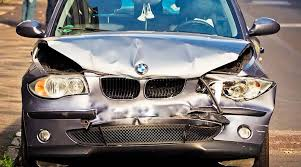

Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.
Determining location of damage...
Assessment: Front damage to vehicle
Location assessment complete.
Determining severity of damage...
Assessment: Moderate damage to vehicle
Severity assessment complete.


In [74]:
engine('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExQWFhUXGBsYGBcYFxgXGhgYFRsXFxoaGxgbHSggHh0lHRUYIjEhJSkrLi4uFyAzODMsNygtLisBCgoKDg0OGxAQGy0lICUtLS0tLS0tLS0tLS0tLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0rLS0tLS0tLf/AABEIAKcBLQMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAIHAQj/xABKEAACAQIEAwUEBQcLAwMFAAABAhEAAwQSITEFQVEGEyJhcTJCgZEHFFKhsRUjYoKSwdEWM0NTcpOywtLh8CSi8XODw0RjZKOz/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAKBEAAgICAgEEAgIDAQAAAAAAAAECEQMSITFBBBMiUTJxYaFCgfAj/9oADAMBAAIRAxEAPwDXA2MYkkWwSTOoiNhp5aCr5fEgS1iepJ2qzjMTbQeC+zt0XUftbVTfHXXtnM2kxlzQf/FeUop80en0eXOKfm2HdKGIIDg7E86WeBXrljHM6mDkGYkaMDM0YvJpA01H41SwBDYi6fskJPoP969D08Uos8/1cnsGbeOfOzKTJ1J6zJqxiOJN3bltsjTPoahtXIbXbyiaqdr72XCXWWQrDKCd9SAdqwyJSyUdGFa4rOc8Nlh3aqSzEKqjdixgAepIFOHaC8mHwq2UggKUBHvKviut+u7gf2X8qEdkMKe9N3lbWF87tyVT1gZ2/UFFMDhhjOIpZ3t29W6d3ZOvwa4SPRx0rvk65ORdDb2awi4LBLeu6My9/dJ3EgFV9QsCOpPWuedosS164147uWHoIJC/AKop5+k93fCBLRBKkPeUe1kDELp0kT+rSJauqFslxmVWtlxMZlDKHE8pEia5497CiiPhb/miRupn5iT84omLwiSY6zpHzodgEtrdvW7T95akFGIglTMZhyYTB8xVbj2L70WptguEQMJy5iihQ0z7RHzG40rpw5pY5cLsyzYozXLoNIwYAgyDsRzreaj4Pg27pQFOkwGKzGYxMGKtpw+5MQPiyj75r1IytWeVLVNqytcbyo7gMG5toQp1Ej0O33RVUIUEZEYwZPhYbzInTaB86juYy7MnN+0D901UcjXRzeowLLFJhDiXD3S0bhUjLzkcyF/fQyximuMlv7TKo9WIH768xmMLWyC3w57jzqfsfg7t3ETaALWke4s6AOqnu5PL84U+RqMk+HKRp6bD7dQTbCH1Qpav3SSe5KwBGxYK2b9IZ1MdJoM/aF/c0PXpXTsN2aW4MSjF0D3LhgREXLfdzruRAYR0Fchx+Aezce1cUq6mGHnv8iCCPIisfTzjktM6vUQlBKg1wlC9nPqTmbMdzmmTPnBB+NG+F9m7mJtuVcKIYLOpLRoPL1pU4ZjRbXLmI8U+Xx0o9w3tKts5lOUxDCJDDzEiuqc5uNQ4Z5C9PGOXea2T8eRUuYW5b0uIyGSPEpGo0MTvFWLFuRRTtLxk4p7ZLSEUwIgDMQT+Aoct0bUlKVcnYop8rr+QrhUAjlV35fvoKl6dKl+tRpNZyVmi4LmMsq0aa1twJe7uaHwtp/A1St3GaStQ2MXDCetFNqiemmW+3OBNt7WKTnCsf0k1UnrKgj/2x1qTDYhQQ49lxm9A0Zh8CAT6HrTBirH1nDPb95l8P9tdV+ZA+DUj8GvzaKxraYMAfstuCPXf+1XI1tFo9XBKmM9+wD1rMOETXLM9YNecJu99ZB95ZRvVefxGU/Gt3EaRXE21wegkmbnGJ/VCoHxa/wBSK9aKjNCm0LVEVzGW/wCoFUr2Lsn+hirxqFkHStFkJcBexASfCDHnVQqKZbuHU8hVN8KJ2qtyXE0PE+7MMjDyYEVvY48h3kU8XL5c+NA/k4BFA8X2VsuxYKLc8lOnyNedHNDyjteOS6ZDhcVnGZYyKwzuxhVnqev6IknpVzh2Ew6i4e/zOzFvDbbKegzGDy3iuYW+PXjAnwL7CwAFnyHM8zueZo7gO090QCEI9CP312wio8HHNKbtjvcZVMkgD9IQPSZ/GKFdsMUDg22gkQF1jUcuVFuMcGfF4C1iMJ4pB75PaII5L5DpvqNaTfydcFtM4Pdlgsz7wMEEcmGpjypZMeNyUol45zUXGRY4ezWcPmGjAFxp/SXMqW/2ZBjoGpk+ijh2WzexDCDcfu0nlbs+H/FM/wBkUr9qbjAJaTVyc0DcvJtIB55je+S014i7ibCfVbQtNZS0tpjLLe71wQWBMIMxJI3knflRlfFGMnXAlcZ4q927ibysQC5A/wDTCqFBHTYkdZodZYfVzrqA33Sadzw76uGD4ewVGrE+PMSI9t4WfIEelCMDjLIDKmHuBWkgZEgA8hN2Y/jWfuccGeKezddftC5wdiLzgfpfiK94/fKXD3TkA2ER8pOsg51PX08hTHdx4s/nLdou32CI0iCZEjflIqjie0i3JD4Z0Y84WPQkkDlOppqTbs1ZX7NZmsc9GI58wD++jEHuGGubvEjecuW7PwnL8xVzs3xiyltkK3NWnRC3ID3J6Uat8Rsttm+Nu4PvK1348/xSOHLgezYl52HWve+PU/OnLF3LZE5M/kFmgONwjXGGSw49EbX7q6Y5k+0c8sLXQIa5Ohmnnsd21sYWyLLYcjWTctwS56sGjX47DSKWh2fxW/1e7+w1et2fxW/1e7+w38KWR45qpP8AscI5IO0v6GDiPbXFW2P1dgLTy6B1BYBmYbyeak896VMfj7t+4bt5sztEmANhA0AA2AojxDht893+YveG0q/zb7gsTy86HvhbiGGR1O/iVh+I8qnHpFcUOayS7siyioi0VZ7piCYMDcxoPjVzCth0tEvlLfZnUk/83rR5EiPaYGSSYFXjgTCksqQNZIkmTy9IqO5iACdVWdfs6HaPKvEAOuYH4zV7WZaUH+HJhFQLcUO+5uDEG3pyAUpl+ZJ/CreG4PhLhA797SsRJuKjiBM5bqHLz94D91LbK0akn4moElDK6Hr69azeNvpj9xLhofu0/ALeE7prTMUclTmIMNGZYIA0IDfKky5jkBylJ5bjWpTxe79XbDls1uVYA+4ymZT7MiQRt4p0NR3rSkAjfQzRji4r5chlkpcw4D/ZzGnMUOkAEDTYaHb4fKgnE7H1fiBjRL2o9L37hcBPoorbAX8l9DPMA+jSKI/SHg5s2r32WNs+jjMPkUP7VZzVT/Zv6eRW4BdyXmt8nEgfpJ/sT+xR28RoCCZIAAEnU8vhJ+FKyYsLcs4lhKyjuBpIJyXY6alo9KIcZCX76hLy/V7F0FnzBWcqdCqzmCxs3Oa4skPlfg9aMuAsyLmIQAdM8Ex5jatXRgJa2jDyzKfhlMfMGp+KdvrBJ7tQoGxAAJA9KU+I9ri3vH51SyxqtSPbd3sFO/ts+VMymJyPGaeYBGjddgfLSvLttuh+VImLxrXWVbcm4SMsb5twQeUbzyiuoXePXeifs86wn3wbxAptt0PyNRNbb7J+Ros3HbvRflWv8pb3RP2am2PgKiOo+dTWyOq/Oo3xaHcT6LW9u/b/AKs/s15jR3Jirx36PbV5zcsXe5ZiSUbxW5OpKwZSTrGo6AUvXvo+4gnsi1c81uAf4wtdTV9IWySPSvQX27lx8K2jnyIyligzmPDsNxzBhmso1tfei5ZYH4FiPjE0X7LcBx+KW691bmaQ6FrqFe9JALv4i0hJA0J1A2q19IfF3Sw4USFykgg7sQAXjYdB/tXM+E9p7li4t1AAysHlWZZgg5TBgodQViCDXZinKUbOWajF0dZufR5ifrFu81yyFtvbbLLElbOSAfCACcpPPVjRXj/DExEo963bHMhsxI6aKfvFN/DeL4PGWRcsC3dtmPdU5TvlZSJDDoajxHA8M/8AQovmqhT/ANsVaSb+f9GM+ekIY7L4GQWxRYhco0JjWdPCNf41dwfDsBa2vMT1ykn5TH3Uw3eytjlmHx0qpc4SU21HpW+mF/Zk/c/gqscAAAEZ438A+cMpqI4nCr7Ni58Mq/glWwkVuiCatRxrqJNzfkpNjrcSMNdjrnI/y1EOI25/mG/vmH+Wi7GNKrXLY6VacfoVS+yBeJWv6g/3zfwq3ax9k7WPh3rfwqo2H8qjOGYbCk1FjTki6eIW5j6qSfK4TWt3iVtDDYa6h/tkfeGry1bZRmI16eVX8TYzLJIIOo9DtSuK8DpvyUV43Y/q7o/Wf/XWDieF+y4/b/3qK5hYrTKByqqh9E/L7LYxuGOxf4OR/iFRvisLsXuj9af8tVHUGomwINNKHlCe/hhAWsKf6Vv1o/hWp4ThH9+2fW3bb8aH/kidyKy72blZS4Z6MNPmKeuL7FeT+C9/JXDHbuj+pH+FqrXexVrkoPpeur/iJFCbnC7ycp9KhDXkPvD5irWJeJGbyS/yiFX7HqjEd1ecfo3FYfMWwfmKpXuybCcjOo1yq9ttB0zjf1y1qvF7w99/mant9o7w/pG/Gq9qfiRDlj8xAt/s3ilBhEYxpluQef2wtWO1uOxN2ylhcJeUZgzNAuEkSAALeYASZmelGrfay/8Ab+YFT2+1d3mEb1UGh48l26YovEurQk8PV0tw9ollZlyOjAkXVMaaHQhj60B/JWJuKQbpS10VBsPtezJEczXVcd2uUIBcw1q5qMiZYl9xB1yxE5o0ilrs12gttjblvLbyO+VrduSoYjKGAYnrlJGh000EcXqNo9no4XGS4A+C7DW3UOMW7qRp4ApnmD4jB8qu2Ow2FHttcb9YAfcJpkPCfq966qA928OoEwPaDR8tRyio3auRTtWmdGqKuF4HYsj8zbVT11LEdMxk1FdGtXBcitLkNR2Uge9QsKs3bcVCRSsdDVbuKdkI+FWAPI/hXk2xEu+vnFed/aH9JcHqZrha+jpJwY1Iaf7VQcRxht2btxRcZkRnCZ/aKgsF011jlrW3fWj75PqP9qwJYGrfMKzHy0FCXPImxS7eYz6vw7KQDfxlw3WB8UWw0Wt9xHiE81muMukV3/tPwHD47CG8hJxSWUtosnL+YLHKq6CWzNBJ94ec8HvW21JBr0sdUcE07JuC8axGEud7h7rW36rsR0ZTow8iCK7R2N+mGxei1jlFi5t3qgm0x28Q1Keuo5yK4TFexVkH2RahlDKQysJDKQQQeYI0IrDZr5b7H9ucZw5vzNzNamWsvLWz1ge6fNYPWa7/ANh/pBwvEQFU91fAlrLHXzKN749NRzApDD13hqNuPlpQXiGEyNKzl2+NNRSq/deIzzH4U1NoTimKqWiTVyzgwd6OXcGOQqjftFdTtV72TrRTxGDA2qBVir9qy7yQpC9TpPoK1uYampCopW28UVCXlz05elQXMRluOOYWR8YUfjRbDcKKqGuELOwJj4T1pt0ESq1uonwoNE7litO4o2CgZ9VAr3u6InDGtThTRsKgc4rMJc1Kmr7YEmqz8NuAghSfSq2QURvFaGzm3E0f4dwpSnjEmev3VeThyjYVDyJD0E78jBtlqN+yrMdE9CDT4mGHSpVtxS96S6D2o+Tn79gbhiLiAeeYkfdFDOL9j7+HVrjZXRQWZl1ICiSYMH5TT7x/tDhMGubE30taSFJl2A+yglj8Bzrj30g/Sb+ULLYLB2rgtuRnutAZlVvZVAdAWC6k67QJq16nIvIn6fG/AkdouLPeY20BOsEjWFMQg+PtHrpsKt8CwFyw9pxo/d3C0folSnycodOnlVjsvwdu7zGBmI0Ya8t9dOfyFdO4XwZLOCuC6RnvBVBgeAZpQAHoSWP+1YqTnJtm2qjFAbtZcxGJ7hsKyIchJc+0i3hrkMSrFSykjrVxxRDurdu2bXd+IxkefZRYAXzMT671TIrDr4rpG6XkrMtQuKssKjdKEx0V2MjWoHtdKsOKhNPsQwNZ6HN65axcNPtWjp5j9xrS2MQOnzJ/fVu293mB864W6OmjyzgUnRXHx/3qtxfG27RWyWILgkzyUQeWusgfEDmKu47F9zZe8wnKswI1OwHlqRrXHMZxu5cum8X8ZJ5aAHkPKtsONzdsyyTUeDotnioQkxC6QDuAOcDQc9NSZ5QABPGuD2LjtcyqA2bvBqpUtBLzAgEtMydQeopf4fxZ7pyKjXLnRB+M7Ux8N4Fj7jABEUQBBZmaOnh0G3M8q6Zax7ZirYkYnsqS5Nu5ajKNCSDOx5EakExOk9KD3+F30Jm2fUaj5jSu+YXsHayB+8vF9ZKXGyzrpBMGss9ibaeItfcfpBH305LmqVkYnFHz63D2HtQusa7z0ga1Gq3LTK6sVKmVdSQQw1BDDUEV9CYjsnhkguXM7DKCfkqSOW/UVN/I7Clc3cuPUXBp5gJHzqvcf0TovsD9i/pSutaRcXZuFgIN4ZArRsxUkEGImAdZiJgO+H7YYS5BF0D+0Co/aIj76WOz/ALWCx2QKGGLSFN094hNrMcqyCQYY840XrFOWK7OWnBnD4cGIzKO7YejqoYfA0++Q4QRwuNS4JRlYdQQR91WAa5X2ktfU2PeYpbHskZh3/tlgoUW7CuWm2dSTHM0LXt7h7e3EcW2h1FgEaHUxdRjyI+JoVg0vs7Q7jaRUZRWrk9n6UcM0K9262oEthgDLbey4GvpV7A/SRhGIFvFlQQT+etQoA0nNlmJgDXU6U+SeBw4zweJxCSLiKYETmjUD5gH4Uu8Mwy37RxWIy4gshsXrKCX8TMAGObkD5Vbwv0g2wYdrF0fasXUJ+NotmB19KEYr8mPiBibSXEvqwaFVBmb0YHbfXQRpFXHLry+SJY91SdDD2Zwjhryad0CO7A91dRB1IzGNY0nUATTAMHSdb7cZX7pLR6ki1fuEbAlotxzGpYipr/0h2bft3rAPQuin5Ziajd/RpqNwwYrcYQUiP8ASnYAkPYO+nea6an3OVRt9LmHHK2dtrjc9v6PnQnYqOgjDCtjbA2rn+E+l3BOYd1tnzJYfOBV+/8ASNglgm+IIkZVdpB2OgOlFjocMPbgRUsVzXG/S3hVEol64OqoFAnmS7CB5mlXtH2tuX76pje9TBkEmxYJGdSSq95dGrgiWhTG2nMqwo6P2h+kDC4YMLa3cU40K4dDcAPRrg8A21EkjpXKO0/0mcVvgrbUYK2fsybked0iR6qFpn4Jwvs/cgWg1onk17Ep/wDJp60zr2JsATaN8ryNvF3z9xuEffS2+h6/Z86PgWuvnN3OW1ZzLMTzMkyfiaPYXg9rwopc5pDMIHhEEkgyANIiZ18pHah2NWT+evDMIIco8jpLIW+/lWW+y+HtOrstu5lMkOgSTyOZU19NBQ22UqQjPNkW3uWnSVzgMsZixJnSR6c4AJAqo/Gblx1k+ESFXlB+6T18uXLpPaz6zft92lvBNm9nvL9zN0zKFT99It3shjE3Wy39i5rrpOWCdPKa6IZYqKiZOFy28l7g/GFuDuWaWHssdJ6/8HU8qtXF5Us3ezt+0fEO7jUNcJtrI13IBkfD1o3w034y3lIYbMIKt5grpWOSu0bQ44JLgqEmrLrVe6tZFkVwVXKVLcFRMTVCGp2I91o/a/CtU4iBpqPKCP3VQtYtd84+Mg0RsvJ01+INedR1pgP6QOIL+TroB1Y2wPOXXQT5A/KuYcG4QL+pdgBnLKo1It91oDyP53X8OddF+lOx/wBCGCxluoTtzzLy/tVzfgHEGsuCpAIOZS3s5oKlX/QdTBPIhTsDXf6df+bo4835nUew/DbXdPcS1FtGCBQCczQCWbm0SN559KbOFYhO7uuukALGoIzHX00B1oJ2J41g7gNhWFm4zZnsXDDIxABCz7S6Agid6Zot27htwMjiGMj5/j868zNHIvUKUl8f2duKUXgcI9/9YOwHG373KBIeAAI0AS7AHKM9s/dRfiHEyjBDBOWTGkxMx8RVe32fKhe79oH29trd9AR8boMeVMGK4YjHO4khQNfKSfxr0VFtcHA2rAHEsYWtKUZlZ9J2Ya6H1IEafaJHKphecWC4Y7Kdc2xO8ge1OsDb0NUMRxnCoWS7iLKToqm4mfTnlJnnGWJiOdSrx6woKK925oNLdi867awy2457T16UkpD4A+PsBs9lWBvJGLsEk6NbcByNoWSjEcyzU5XuLA20uDQOqsPRgD++kLD96+OOLaxiTbFo2kRcNdEKd5zhRrLGNhIHKtbWLZbVvDR/NLkJG2hOX5LlHqDWsU65FwwD9Mt3vbYPMBI9Fdgf/wCorj42Ho1du4/w43rUHcTrGaAwykxzjRv1K5Nf4Yy5kI8SBgYI1LkRGmoykMDzG0b1pEmaBRH4r+Fart8P8wove4cwYwpgO4mNxYQGduetRWOHMxC5dSUTz8Y7xviBvVEUUGB19W/DWum/RR2nu2UvWixKqEZZJkDxCPTSkR+HsE7yIBthusG6z5FMbEojNryFPv0bcDLYXGXyNHDJa5T3avr56sB8KmT4KiuRc7d8exGKxJUliqFYQEn84QJ0G5BYqOgX1lVvKy+EyPdiTpDTlj15daZuLWR9axAI0a5dceHN+bY57TCORlfg9WPyUA8eGM4UxyGTPcBH6P8ACi6ChSVGJls0eIzqdSPPrpXi2GPJoBA5wNOtNb8KbLzDZEGfX2nc5DJG2US3TSYrMXhAFzgkqHcZvcIdZVAdwRBJEaCNRIk2FqKiYRjAAkmAANSWY6AdSa6twvh4tIFAUkaTAMhQEBzc5VVqj2M7FXDdS9eBRVAy5okkCAwAMgDQiYMweQzPh4HJhQPwHwpOSKihO7RC7ftfVbft3SFAHvQQcvlOmvSaE9juIk2jhr85QYVj4e7JbIFYnXKzKQZGhAbkxp84t2LxT5Xw9xFMZWDBtiQZGXWdOZA6zpALiXZLitrCi2ti2yrcNy41tkGcAiMys2ZhoS225A3YtPD4KbpjN2T4VcdxbFi3bsWyAbt5Rde80kMLVosVtLKnxMCTAPkr9xW0LOHutay2iEaGFsHKY0OURm9Odcx7H33W+qOLq4hTaTRiAbbMMrup0YZSwLQT4FPvaP30iY63awZF0kJcdbbZQScplmiNZhSRGpMAb0l+LYn+SOV4zjvFxeKLcvOS5y+HuwRqNVOg0gxMDXfemzhYxIt3frN8W29pkBFy4IUKx8EhFJ1iB6zrS72Iurau3reORYvKww2JGW211LhPeBWQjNmhWgeJSWU7gU24fsy1oKLdy4qCXaTMgyPE+8hcuupGXfecslrhlpp9FDCcMNq4uJtYt71tg2a25EaqSIPKGUEAgHwkzpBYfq2IcnNcBtspKgGCZA2I5eYPnQbs7wcqWRSGViSXBGVJ0yzvmIjSNIBmnmzbyKFUTA32gDl6VCjKatsbkovg57wvimKti4mIW54SqoXBhwQSRB9rLG/mK84ldS3YfF4lLVq2PZAUpcuEa5VyMJJAOvLU7A0c43xsDEOhsd9kUZEQw5uEmS5PgS3AADMdSGAB0BGWuEXrjticXcFx4i3ZUfmbC6EBZGZ2kAljEkDTRY0hBrtinJSdpUK3AsU7Aq5kxnAIbMqsdAxYzJkQDrCydGEkLi0O4Gv5/Eseqj4+Mn8RRZ60lwxx6KTioGFXLgFV3WpGw53AG1qfiP3isD6k/VifMR+41omObm6H4/71PhsV+kJ9f41xUdPAE7fXc/Dry9y6wbZk7CLqTrXKsDhc7Bf+CuwdusSTw+8OZyKJI53EFcjwL9K7vS/h/s5M/wCQQsYQOMjgMBtPLX3WGo+BFG+H2sSulvE4lB9nvM6j0V1Onxqrw+JGY5fXT40y4LF21ibifNf9VdTjF9mX6CPCbfFI8PEHC9DYsH7yJoseGXrgy4nEXb/k5AT+7tqqkf2garYfjVlQJuWumty2P81Wl7Q4cf09j++tfvalqhck2C4DbUgKAB0EqPkNKbsDaCgClO32iww1+sWP763/AKqI4btJYOov2P760Pxak4hbGzSKSOLMFuGVgsdPOi1/tNaCE57XqL9j/XShjuLWnvC73isRlUL+cbc6QEQrvzzdKSj9jTDljCnQxFC+LdmbV2SFAJ3iQRrmIBUggEwSvsk6kE0Oxnatxdaz4SwYrAPTT/mlMHZFLpDte290DpScK6Kv7Et+wKD2bl8Tp/OLG8/1U79Sd6nu9gVI/nbxMsdLiz44BH8yOQ+811bCYZHXMRlHKY1r3EXLVrcj7qj5BaOZ4P6PkbS4Ll0Zg2W5czKIBAHhVGA168hTvg+zpRFRcqKogKogAdABAAozir2VQyAVTw/HF7zuz7UdKNWxbV0LnFPozw94eLUcgS4A8hkddOgMwAAIAAFQfRNhp9knUn+cugSRB9/yp44bxE3XdQpheZEUK4u9xWIVyPQ06YrAmF+izBLBNgMQVMm5d3XbZ/Oj1rsxaQKFS0mScpVFBGYgnxATrlE66wKC3rl7ndf4Ma0coy6F83OWJpUUNFrgyDmCfWpQ1u262yMpb2SdiRrAPWlTB4dSousug5HnFS8Rxve4du5V3ZGU91mG4YGVY+yQJMj75opByNGPx4tjQa/woa/HSB441HwpKxvGWDZXe33oGge/a5CdbYYHl1qrfxGOugALZdY923dK6csyXfwp2g1KPE+M/wDVNibYyXrHjdRvctSBcIHOPC/mZ610/F8fsXLdkkg94uYD5D+NcoT61hbouHCpcRly3UFu7NxJ2Jd3II5FYIOuo0rfgzW2JREJAINlWuFH7m4SUEiZdWDIR5eVD1/0OjoYwKWyXtXHtBiCVVgyH/23BUTPugHzqhdx99XdDh7VxXUeIXbgQySJa0zkKNOU86H3L13nhGPkMT/GzVa/ibhj/o7gI2K4pfl/M1OsQ5GAW75dLllrdmJDpCLnB5k5LhBEecgnyII4jh969HeYogD3bKi2dQRBcy3Pdchrn2KxTkgumKSNNGt3dAOsW6y3xnJ/9RcXoLltgfjlDj76uOKPVktsfcLwBLQhAAJnqSTuSTqSep1NEDa8JFImD7XuDAu238s6z8pmmPhXakOwS7aZCecaffTeFrlCUxM4QuW5iwRtiCvwCWyP8Rq+6jzHwqbGBDdutbPhe4SD1iFn0OWR5EVAw86wbtm6XBA6elQMvWPnVhhUFwUBQRXhiHl6RMVh4Yg5ka9RXhuhPEYA8m+PMUJ4jx6fCgMbTp/qrkipS6N5OKK3bV7aYaFYkm7aHKNLin91cwyhrWQCGViwOmoYKCpPlkBHLVutNPbLFzhuYOdSNj1NLZHjbpmMehOld+KNKjkyO2Ue7f7B+C/wFeqr/Zb9k/wozZOlWLYrWjOgPaF73UufBG/hV3Cti1YN3V0xyNp4P3USS2KIYUaUmykgVjcVi7mWLF5YGwtXI/CobdrHHa1iP7tx+IpiFok6CpURxsPupIdCc3Frykgs4IMEQdOXSr3Csdib7C3bD3WeAFUEmQQwIgSIKiTy1pi+osxCorq4YOPFCk66NKEFCTqp5VrgO3Hcm4tu272Zy2UtALKpoWdh+cIbcAkQOtJO3yDVeToY4bh8HeAIl7xLl38TlmOYgnYRMRTLbvKqE9BOlcbv9vsRc0tYUArGjeMiZglcubkdc1aWu0fEmJmVB1IWF+PiNOTQkdJvcT7yStu6dRsjnr0Fa4IXLlxVuYe6VmZ9kLz2YilbhnH76iGJ1I9q6vPYCCdTyFG8N2sOpm1AE/zmsTlkaajNpI51k5l6jZ2h4s1lR4ctsDV2KwPgpLH4CgvDcVfvsLthLbrqpcXFBkbqdPQ+hFAu0nExihbRiAivNwDPJCkAjRd99OZ2re1xnuMXevWARavZS1t1YQ6KFJESNgJM7wN9KFkoWg+vxS7ZQZ7dkMdl70gk/C2ZNLPEUxFy8txns21B8SC8bk//AKlg1XxHakMFhGUgR7Dc9Y1PLn9nnGlBcTx1gZ8UHXW0Zj0J5bkbxrS91sPbQ2Xb6wQWUfrA0svdureYi9h1t6QS5Y/FYH40Dv8AEixMl/gvXYb89x1oTidZOdo65eXXfbl60XZVJHS8T2gw9xMl27hxpoy3EAB1/Tny3pU41hUvo9tcQjCDFu1fhDJ1Lqryx8tfTek+7ggTq7fG3zG49rkN+lDgFzMivqNpVvEQQCBlmIEtJ0hfOmo/yJtfQesdmLYhWwz3ASJKWLysqyJIJOVtAefXXoSweDwuFcNZNp33gOgIOo8S5s4jbbqNKDcLxotk5hmOsZMpOYbiCwYesUYtdocVn1s4i5a08OlzSQTKnMNp086b/Yl+gjhuFd7he88D3BpkYKSRJ2b2gdZGo2pfWwoGguKc0EI0MJnMA7BzbJJPsrznWocVjf8A8JGZgZ/MtYMeZs92AfM1HgsTcunu7KXFvmAiPcS/bILKDLwHUgNMEnb0FFA2dC7N9ncNiLYdMdxFWGjW/rIJQyRqIIgxoeY6agHl7CgjTiGM/W+rt/8ADSx9FnCcRcuLirzoLeUwqzmaRoCZjKPTWB610vi+OtYe0166wW2gkn7gANySSAANyaukRbvgSMf2FfWMfe/WtW2+5ctLmM+jzFe7jlPraZP8Lmjt76RbLQ/dXFtGYcxyJBkbCI5tRX8oq6B1PhIkH18jQqHTZzC/9HuKDQ+ItAcyM7H5ED8aK28ti3bwOHYgucpf3pbV3+ABMDoKNcZxykH84AfMN/lBoN2awM4g3e9t3IQwELEqWIHiDKCpifnTcqVjjHkY+5CqAogAAADkBoKiy1PdHz/5yquSa5LNyN6h0rdmFQMRVAK/EOOd4dAMvpr86Hvi41IA/wB/jG34VWuR1j5Ve4Lw/vmJeGROTczG3n++RWqVLgwlJthLtvwEWeHi6bgdnuINFkCVuE5X+A5UkIZAPVV/AT980w9p8NktlMqgZ1KFQFGUhhBHMiAJ86W8HOUeRI+Rn/MKuBL7COEsu5yoJMqPi7KiyeUs6ifOuicP7PYS6qi4lwuVIL2stoKQShKIgK6ESMwJM6zST2exqWrjC5m7q4htXCurKCVdbiDbMly2jjrljnThw3tJcwjZk7i8hlmZLqZbjSzL4W/OWZznMuU9NaWRSfQ415AHF+Fthr72GYMVO45g6qSORKkGPPnUdt4qPEYx7167funM9xizEaDyAHIAQB5CvU1pjNeInEe0l0qhWRlAmVjOCSJkTPoynnQU3bhMNdvtyjO0zvETvzjmNqY7F7LuMymCRMGRsytBysJMGDuQQQSDBxPhyFe8VhG07GN4uW5kRBOZSQDqGmRTE0LD2yGzI5UxBYOZIeVPi+ywJE8iYMVdtXii5QNACNc3LqN9PeXfmsipnwrHUeIb5gVaZEabAt8AtwDWDrUf1R/snSNg0abQYkAcm3Q6GRSJ5I8PjGF4NA8QyNIJGuqZxPi15jcHqKNJjiD7KjXmBMt1bUZj9va5ouhoBicK24Vhz0Ug6c49d12nUVewRZlDBD+qCY5HlG5gof7Q1oaQ7YZHFHj2lEAzplEL7UiJA2zqPFb0ialHEbuaM7zmjQ2g05cw1jKHK7E+A2/06FCzd+xcnTruh0hiJlfdfcHR9KspgrhPsdRBt6QfFBTTwk6m3zbxrppSqIfIJpjXI9ttpESPa2KzqBuELa29WuTIrw4tts7Tm0y5/skABNZPS375m7tpVa1gLx17s6wd5Ou8tzbTVv6QQrARNW14bfI/m25jcgeLkSPEAeZHiWAqys0viHyIlvGNGbZdrhcbwsHZxOgJ0vN4TEVAzESS2mplrjQAvMvuArnW5GYPFuCutXRw2/vkfkZJQHUQZAOUMdiB4Qo8Pjmt/wAm3Nz4SNZzIDIEAqWMAxohOyznBNFxCmBruGJBGs6qQTGvturAeyY8TqP5vQpMkVGcMZ94knSCMxLL4Y90uy7e6yiTDUYOBjTvLCgZRHeWwITUAAtOVSZUbh9SSNKjGADSBew7aMI72205jmIbKdQ277ZmjLkp7IKYCfDbAGdEggyImAROpWZye8SDmERWuKwao7AN6GdcpMgnTbLAkQDoOc0a4lwW4VLAhtcwIOZpj2pA9swATtlAG/iqrw/s/iGVWKwSFjRgQAgVd10aAFjYdJpbIaTAl20wEzoJ/wC2BqDtBMdFmDm3qqW6/eOn3gj5jyGlPFnsjiCNiNohDpHSQPZ1CjzLGdqkTsqUgspJGwhQumqjcmFOvmSSeQo9yI9JCVhi7wF2HkIXbU8gNdtj5c+g9kOAXBba4UabiZEMlSqGCX9TEKPMtp4ZjwWGa1dR/q9traSe6f2STqDME5w2uYzPMTBDQvbcj28JHmt4t+NoUKSChi7N4cWUCAQBy6VF23RL1q0Ls9yl+290DnbXMCI6SwJ9KBjt5YG9q8PQIfxYVj9s8K8znGmoZJ021ylhzp2Kh7vYBfCFRTbjVYGSCNIG0bVz7G2FsreVPDbFy2Et8rReyt17aneFLKQOQdRsAK1tdr1XS1i3VAICELA8la5bJA/ChOP4mt2ArplWcqhwxljLMxJLM7HUsdTHlSjCnZRBxDEWSstbfocl1BJPMK1tiPma3+j+4hvXZBylJWTqAHA1Igcx9+1BOInwkn/z0A03NX+wuY3CAYPdtt4TAe2NNp/551Gd1E0xK5HQO7ska/OYgfxqJ8HZ6z8Sfwqi+Ed/EW2HvE9dQNNQY5dRVNrUGQwK+R3BG8f8BiuO2dWiCt7C2dCWAHLxRIPqP+RtVZsLYG7j9sf6aHpaOViXUDbMWUbbTPWfvEV6bboBmlZ1BBQSPiRpJ+809g0RzJpbYfFZOhO55DpyowvDUUZ1kMBIhrgJ0n2s8R8J12qjgCgW68EuuUxyAkgy0QBLLv0PSiyXJXMQMpXOTsMoJkyY00PyrpU03R56asXuL4pjcQMPsn280qJyj2RBEnlOtBcPiGXYj2idQDuB1ojjrneF8QoyoLgUA7nb92/LX4UFN2J9a3iSy8MS9SLfudaoLiyK3XiDD/wKoVhFbt3qfvqZDd+03zNDF4q45/cKlXjjjn/2igdhRLF0+83zNSrw1zBJM8jOo9KFr2iuDmP2RUg7UXuR/wC1aVBaDVrh1zXWesgE/Mia1xai1oxBPQEiPLQjlQle1uIGzx+qhiekjQ+dBr+LZjJJpUx7Kg2caoO3P7dzl5Z6z8qRtAEkwC6iTE7N5fj1peLGsmnQthnwnH3tmVyk/p5nH7LsRW9ztK7Eki3r0TKPgAQAPIUqzWTRqg2Ghu0TREW/7tT95FaNx8nlb/ubP4FKWprJopC2YyJxuOVv+5sfuSpPy+wO4HoiL+AFK816GopD2Gsdp7n9Y/wYj8DXv8qH5u59WY/vpUz1neGjVBsNP8ozVix2vZaTS5rwGloh7s6xwX6VO60e2HX5UZu9qsJiAblm93be9augz+o6ggjyMVw/PUiXo2NT7UV0P3H5OwXOKL/W2vm3+mql3iCf1ifAn+FctGI862+s+dPUNjot3Ep9pfnUDunUfOkL64ftfdWyYxjtJ9Jp0LYcr7IRECd82sny3iPhNUcTaSBDaxqNdKDr9YbZLh9Ec6fKrN7AYtULtaIVQSSSugHlM0tl9hyzZGl1WdJJ+VN3YW2WvED+rbY8u8tjc7a6/Kkjh12ZbT469ab+wmIYYhoMHun1j/7ls8/Sss3KNsPDHQ4RxM7a6iOmmnXl8TUn5KZpVQx217skCdeRJjadOVaHFNpt/wCI/wCT51quNZSGWAw56SJ5SORIE+lcbizr3I7vCHAA1DTsbbgwI5xEeLrUR4Y52zyN8qn76nPEnAVRAVdFAiFH6I5aaCKiPEW5wfWT++moyFsKC8TS6xmFUgrBBOwMMQBGaQYPrPmO7UXMiBNCQIkDlpAHT2tTvv8AHKyiMVHMqPLfYrFWhgRtruI5Sd+lVbmutZWV6SLYU7NBGuGy8fnIVSQSA0ggaA77T566ai3i+HICQbcGY0PP4GsrKiX5FR5RE/AvDm1APmDWuL4AFy5boJYAwVIifMSK9rKlSZTigXjcJ3ZgspPQZtPWVA+VVqysrZGTMrKysoEZWVlZQBlZWVlAGVlZWUAZWVlZQBlZWVlAGVlZWUAZWVlZQBlG+EY/CKoW/hyzAmLisTPk9tjlMa6grykHesrKTVqhp0xnw3GOHIVICE+VoiJ5Tk36x86IWOOWWMJGk6BSP8tZWVzzwxq+TaOV2FsPeBGaJ6mf40N7ccTRcJ3MQ90wI+whDMSfgBH6VeVlYYopzOjI6gIlu4ARGmn8aZOxLRfb/wBJv8aVlZXVk6MIdje9wefr615cUiQZn1/hzrKyuc2bIiADuZ9TyqN/L79fxrKyqQmf/9k=')